<img style="float: middle;" src="../images/logo.png">

**This script has been generated by Feng Zhang from the *Genomics and Machine Learning Lab*.** 

If you have any questions, please do not hesitate to contact me (feng.zhang@uq.edu.au).

- [1 NeighborhoodCoordination](#NeighborhoodCoordination)<br>
- [2 Cell community identification](#2-Cell-community-identification)<br>
    - [2.1 Get the neighborhood cells](#Get-the-neighborhood-cells)<br>
    - [2.2 Calculate the proportion](#Count-the-number-of-each-cell-type-in-those-neighbors)<br>
    - [2.3 Cluster as cell community](#Cluster-cells-into-different-cell-community)<br>
    - [2.4 Visualization](#plot)<br>

## Neighborhood Coordination
![neighbor](images/neighbor.jpg)

## 2 Cell community identification
### Import modules

In [1]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
import os, time,sys
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns


In [2]:

def get_windows(job,n_neighbors):
    '''
    For each region and each individual cell in dataset, return the indices of the nearest neighbors.
    
    'job:  meta data containing the start time,index of region, region name, indices of region in original dataframe
    n_neighbors:  the number of neighbors to find for each cell
    '''
    start_time,idx,tissue_name,indices = job
    job_start = time.time()
    
    print ("Starting:", str(idx+1)+'/'+str(len(exps)),': ' + str(exps[idx]))

    tissue = tissue_group.get_group(tissue_name)
    to_fit = tissue.loc[indices][[X,Y]].values

#     fit = NearestNeighbors(n_neighbors=n_neighbors+1).fit(tissue[[X,Y]].values)
    fit = NearestNeighbors(n_neighbors=n_neighbors).fit(tissue[[X,Y]].values)
    m = fit.kneighbors(to_fit)

    #sort_neighbors
    args = m[0].argsort(axis = 1)
    add = np.arange(m[1].shape[0])*m[1].shape[1]
    sorted_indices = m[1].flatten()[args+add[:,None]]
    neighbors = tissue.index.values[sorted_indices]

    end_time = time.time()
   
    print ("Finishing:", str(idx+1)+"/"+str(len(exps)),": "+ str(exps[idx]),end_time-job_start,end_time-start_time)
    return neighbors.astype(np.int32)


### Set path and load data


In [3]:
#script_dir = '/scratch/project/stseq/Feng/package-vignette/scripts/topic/community'
script_dir = '/software/winter_school_2024/003-downstream-analysis'
sys.path.insert(0, script_dir)
from voronoi import draw_voronoi_scatter

In [4]:
# set default parameters
ks = [5,10,20] # k=5 means it collects 5 nearest neighbors for each center cell
X = 'sdimx'
Y = 'sdimy'
reg = 'fov'
cluster_col = 'custom_clust'
keep_cols = [X,Y,reg,cluster_col]
n_neighbors = max(ks)

In [5]:
if os.path.exists('spatial.csv'):
    cells = pd.read_csv('spatial.csv').reset_index()
else:
    cells = pd.read_csv('/data/module2/data/spatial.csv').reset_index()

cells.head()

,index,X,sdimx,sdimy,cell_ID,fov,Area,AspectRatio,Width,Height,...,Run_Tissue_name,Panel,Diversity,totalcounts,Slide_name,Run_name,tissue,slide_layout,custom_clust,clust_mel_ref
0,0,19508,12.71464,-7.92352,c_6_1_1,1,5233,1.92,121,63,...,48974-2B,980p,146,323,S3,Run1069,48974-2B,48974-2B_Tissue1,KC_Diff,Epithelial cells
1,1,19509,12.74416,-7.92334,c_6_1_2,1,4565,1.30,103,79,...,48974-2B,980p,57,89,S3,Run1069,48974-2B,48974-2B_Tissue1,Pilosebaceous,Keratinocytes
2,2,19510,12.67864,-7.92424,c_6_1_3,1,3709,1.58,87,55,...,48974-2B,980p,120,180,S3,Run1069,48974-2B,48974-2B_Tissue1,Pilosebaceous,Keratinocytes
3,3,19511,12.73696,-7.92730,c_6_1_4,1,5356,1.56,134,86,...,48974-2B,980p,164,351,S3,Run1069,48974-2B,48974-2B_Tissue1,KC_Diff,Keratinocytes
4,4,19512,12.66640,-7.92712,c_6_1_5,1,5274,1.85,120,65,...,48974-2B,980p,230,533,S3,Run1069,48974-2B,48974-2B_Tissue1,KC_Diff,Keratinocytes


### Get the neighborhood cells

In [6]:
print(cells.shape)
print(cells.columns)
print(cells[cluster_col].unique())

(18246, 25)
Index(['index', 'X', 'sdimx', 'sdimy', 'cell_ID', 'fov', 'Area', 'AspectRatio',
       'Width', 'Height', 'leiden_clus', 'IFcolor', 'dualfiles',
       'ISH.concentration', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel',
       'Diversity', 'totalcounts', 'Slide_name', 'Run_name', 'tissue',
       'slide_layout', 'custom_clust', 'clust_mel_ref'],
      dtype='object')
['KC_Diff' 'Pilosebaceous' 'KC_Other' 'KC_Cyc' 'KC_Basal' 'Fibroblast'
 'NK.T' 'Myeloid' 'Endothelial' 'Melanocyte' 'B.PDC' 'NotDet']


In [7]:
# find windows for each cell in each tissue region
cells = pd.concat([cells,pd.get_dummies(cells[cluster_col])],axis=1)
sum_cols = cells[cluster_col].unique()
values = cells[sum_cols].values
tissue_group = cells[[X,Y,reg]].groupby(reg)
exps = list(cells[reg].unique())
tissue_chunks = [(time.time(),exps.index(t),t,a) for t,indices in tissue_group.groups.items() for a in np.array_split(indices,1)] 
tissues = [get_windows(job,n_neighbors) for job in tissue_chunks]

Starting: 1/12 : 1
Finishing: 1/12 : 1 0.0037949085235595703 0.00412440299987793
Starting: 2/12 : 2
Finishing: 2/12 : 2 0.0041010379791259766 0.008240461349487305
Starting: 3/12 : 3
Finishing: 3/12 : 3 0.002499103546142578 0.010755300521850586
Starting: 4/12 : 8
Finishing: 4/12 : 8 0.003216266632080078 0.013982295989990234
Starting: 5/12 : 9
Finishing: 5/12 : 9 0.003168821334838867 0.01716470718383789
Starting: 6/12 : 11
Finishing: 6/12 : 11 0.005010366439819336 0.022189617156982422
Starting: 7/12 : 12
Finishing: 7/12 : 12 0.00582575798034668 0.028033971786499023
Starting: 8/12 : 13
Finishing: 8/12 : 13 0.01019287109375 0.038245201110839844
Starting: 9/12 : 14
Finishing: 9/12 : 14 0.004861116409301758 0.043135881423950195
Starting: 10/12 : 15
Finishing: 10/12 : 15 0.006482362747192383 0.04963827133178711
Starting: 11/12 : 16
Finishing: 11/12 : 16 0.003552675247192383 0.0532078742980957
Starting: 12/12 : 17
Finishing: 12/12 : 17 0.0019040107727050781 0.055127620697021484


In [8]:
print(len(tissues))
print(type(tissues[0]))
print(tissues[0].shape)
tissues[0][:5,]

12
<class 'numpy.ndarray'>
(838, 20)


array([[  0, 616,   5,  10,   6,  11,   3,   9,  12,   1,  16,  31,   2,
         26,  14,  15,  40, 618, 634,  57],
       [  1,   3,   6, 618,  12,  15,   5,   0, 616, 624,  10,  17,  11,
         18, 631,  28, 634, 622,  32,   9],
       [  2,   4,   9,  14,  13,  16,  26,  22,   8,  11,  38,  31,  40,
         21,   7,   0, 616,  57,  58,  10],
       [  3,   1,   6,  12,   5,  15, 618,   0,  10, 616,  11, 624,  17,
        631, 634,   9,  31,  18,  16,  28],
       [  4,  13,   2,  14,   8,  22,  21,   7,  26,   9,  38,  16,  19,
         40,  54,  31,  35, 617,  58,  11]], dtype=int32)

### Count the number of each cell type in those neighbors for each cell

In [9]:
# for each cell and its nearest neighbors, reshape and count the number of each cell type in those neighbors.
out_dict = {}
for k in ks:
    for neighbors,job in zip(tissues,tissue_chunks):
        chunk = np.arange(len(neighbors))#indices
        tissue_name = job[2]
        indices = job[3]
        window = values[neighbors[chunk,:k].flatten()].reshape(len(chunk),k,len(sum_cols)).sum(axis = 1)
        out_dict[(tissue_name,k)] = (window.astype(np.float16),indices)


In [10]:
out_dict[(1, 10)][0][:5,]

array([[5., 1., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 1., 1., 3., 3., 0., 0., 0., 0., 0., 0., 0.],
       [5., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [3., 1., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0.]], dtype=float16)

In [11]:
#concatenate the summed windows and combine into one dataframe for each window size tested.
windows = {}
for k in ks:
    window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],axis=0)
    window = window.loc[cells.index.values]
    window = pd.concat([cells[keep_cols],window], axis=1)
    windows[k] = window


In [12]:
print(type(windows))
print(windows.keys())
print(windows[10].columns)
print(len(windows[10].columns))
windows[10]

<class 'dict'>
dict_keys([5, 10, 20])
Index(['sdimx', 'sdimy', 'fov', 'custom_clust', 'KC_Diff', 'Pilosebaceous',
       'KC_Other', 'KC_Cyc', 'KC_Basal', 'Fibroblast', 'NK.T', 'Myeloid',
       'Endothelial', 'Melanocyte', 'B.PDC', 'NotDet'],
      dtype='object')
16


,sdimx,sdimy,fov,custom_clust,KC_Diff,Pilosebaceous,KC_Other,KC_Cyc,KC_Basal,Fibroblast,NK.T,Myeloid,Endothelial,Melanocyte,B.PDC,NotDet
0,12.71464,-7.92352,1,KC_Diff,5.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.74416,-7.92334,1,Pilosebaceous,5.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.67864,-7.92424,1,Pilosebaceous,2.0,1.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.73696,-7.92730,1,KC_Diff,5.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.66640,-7.92712,1,KC_Diff,3.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18241,18.01690,-1.14232,17,Pilosebaceous,0.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0
18242,18.21184,-1.14754,17,KC_Other,1.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
18243,18.07666,-1.15384,17,KC_Cyc,1.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0
18244,18.41938,-1.16338,17,B.PDC,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0


### Cluster cells into different cell community

In [13]:
k = 10
n_neighborhoods = 10
neighborhood_name = "neighborhood"+str(k)
k_centroids = {}

In [14]:
windows2 = windows[10]
# windows2[cluster_col] = cells[cluster_col]

km = MiniBatchKMeans(n_clusters = n_neighborhoods,random_state=0)

labelskm = km.fit_predict(windows2[sum_cols].values)
k_centroids[k] = km.cluster_centers_
cells['neighborhood10'] = labelskm
cells[neighborhood_name] = cells[neighborhood_name].astype('category')


### plot
#### clusters heatmap

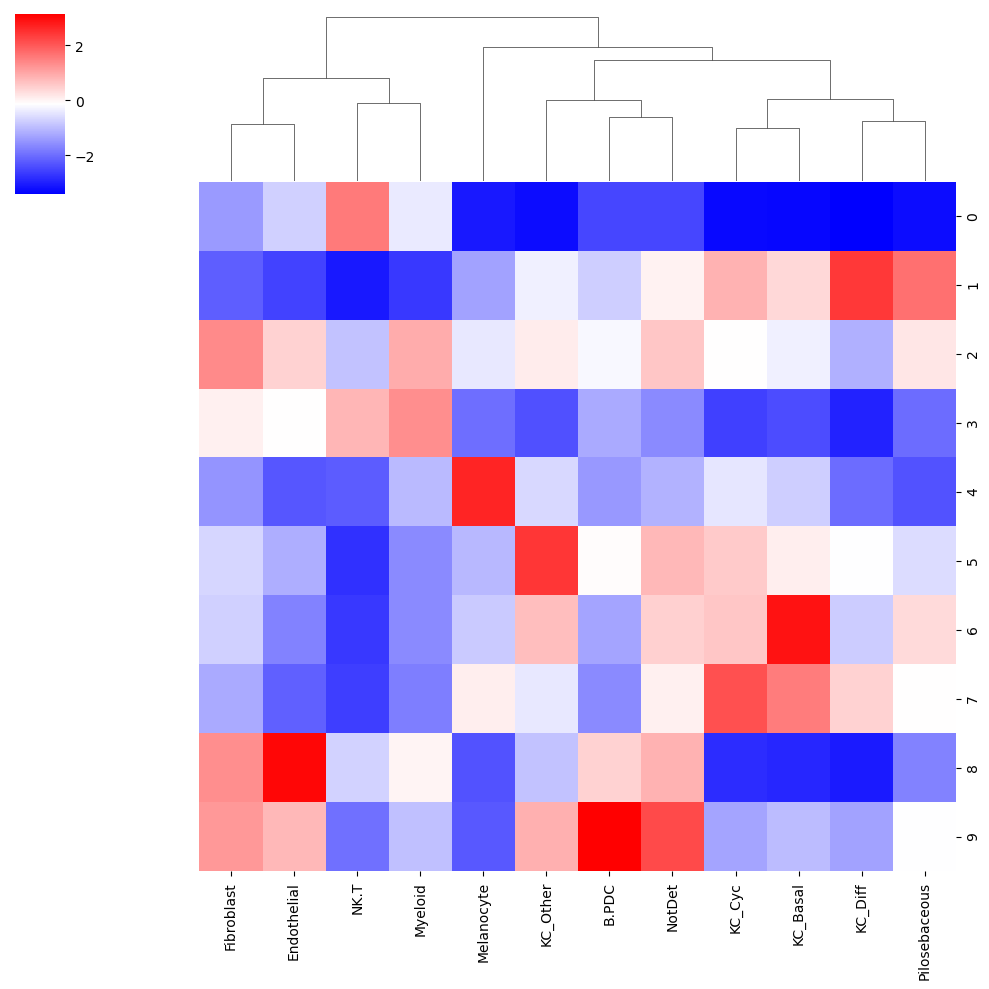

In [15]:
# this plot shows the types of cells (ClusterIDs) in the different niches
k_to_plot = 10
niche_clusters = (k_centroids[k_to_plot])
tissue_avgs = values.mean(axis = 0)
fc = np.log2(((niche_clusters+tissue_avgs)/(niche_clusters+tissue_avgs).sum(axis = 1, keepdims = True))/tissue_avgs)
fc = pd.DataFrame(fc,columns = sum_cols)
s=sns.clustermap(fc, cmap = 'bwr',row_cluster = False)
plt.show()

#### The scatter and voronoi plot

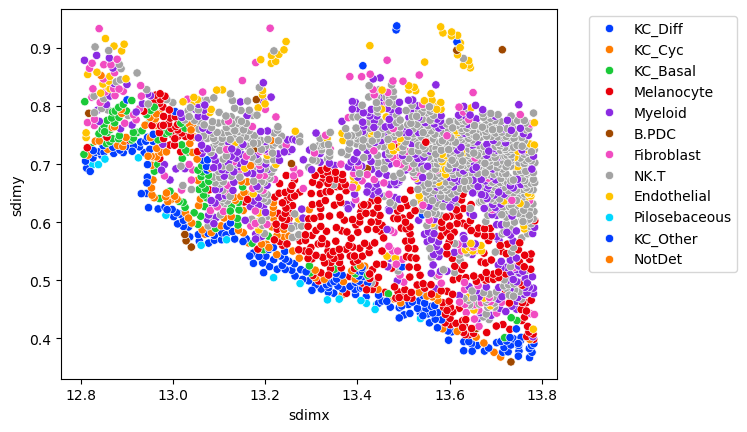

In [16]:
fov=12
sub_cell = cells.loc[cells['fov']==fov]
sub_cell.loc[:,'sdimy'] = sub_cell['sdimy']*(-1) # to compare with hoodscanR results
sns.scatterplot(data = sub_cell,x = 'sdimx',y='sdimy',hue = 'custom_clust',palette='bright')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

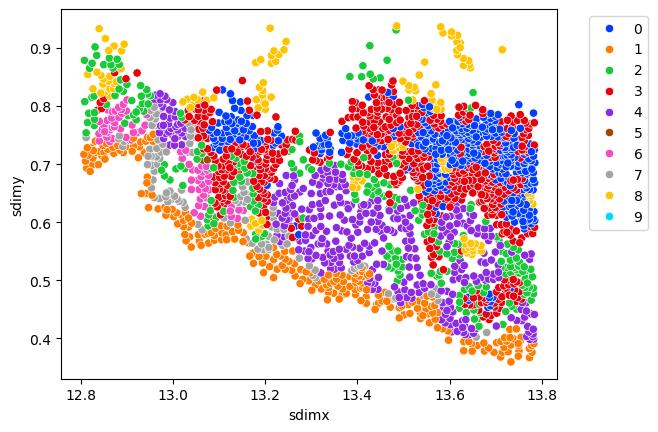

In [17]:
sns.scatterplot(data = sub_cell,x = 'sdimx',y='sdimy',hue = 'neighborhood10',palette='bright')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


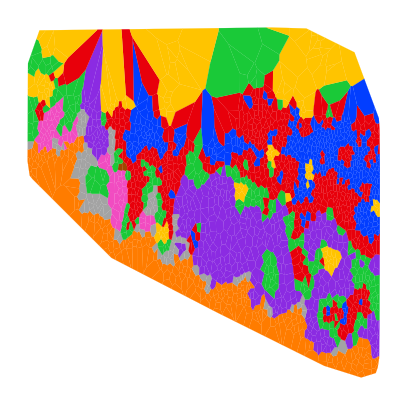

In [18]:
p = draw_voronoi_scatter(sub_cell,[],X = 'sdimx',Y='sdimy',voronoi_hue = 'neighborhood10',scatter_hue = 'neighborhood10',voronoi_kwargs={"invert_y":False})
plt.show()